The aim of this project is to classify the VIX (volatility) into clusters using the Kmean Algorithm.

# 1 Libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# yfinance
# !pip install yfinance
import yfinance as yf

# 2 Data import and manipulation

Zeros deleted 0 on (7943, 1)
hist
            Close
Date             
1990-01-02  17.24
1990-01-03  18.19
1990-01-04  19.22
1990-01-05  20.11
1990-01-08  20.26
1990-01-09  22.20
1990-01-10  22.44
1990-01-11  20.05
1990-01-12  24.64
1990-01-15  26.34
1990-01-16  24.18
1990-01-17  24.16
1990-01-18  24.34
1990-01-19  22.50
1990-01-22  26.70
1990-01-23  24.72
1990-01-24  25.39
1990-01-25  25.63
1990-01-26  26.28
1990-01-29  26.44
...           ...
2021-10-21  15.01
2021-10-22  15.43
2021-10-25  15.24
2021-10-26  15.98
2021-10-27  16.98
2021-10-28  16.53
2021-10-29  16.26
2021-11-01  16.41
2021-11-02  16.03
2021-11-03  15.10
2021-11-04  15.44
2021-11-05  16.48
2021-11-08  17.22
2021-11-09  17.78
2021-11-10  18.73
2021-11-11  17.66
2021-11-12  16.29
2021-11-15  16.49
2021-11-16  16.37
2021-11-17  17.11

[7943 rows x 1 columns]


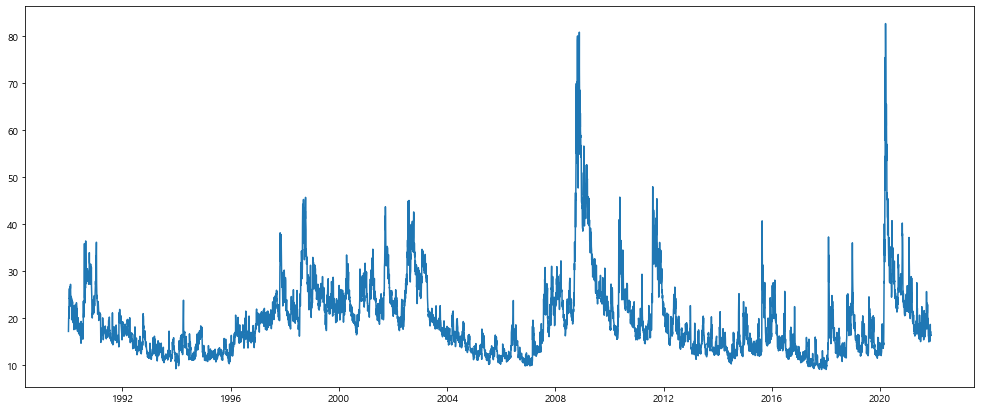

In [4]:
#IMPORT DATA

#Ticker
stock = yf.Ticker("^VIX") #VIX index

# get historical market data
hist = stock.history(period="Max", interval= "1d", actions = False, prepost = True)

#Drop "Dividends", "Stock Splits","Open" , "Volume"
hist.drop(["Open" , "Low", "Volume", "High", "Volume"], axis = 1, inplace = True)

#Delete zeros if any
print("Zeros deleted", np.count_nonzero((hist == 0).any(axis = 1)),"on", hist.shape)
hist = hist[(hist != 0).all(axis = 1)]

#Print it
pd.set_option('min_rows', 40)
pd.options.display.float_format = '{:,.2f}'.format
print("hist")
print(hist)

#No manipulation
hist_m = hist

#Plot
plt.figure(figsize=(17,7))
plt.plot( hist_m.index, hist_m["Close"])
plt.show()
#hist_m

In [5]:
#Initialize variable
x_raw = hist_m["Close"].to_numpy()
x_raw = np.reshape(x_raw, [-1,1])

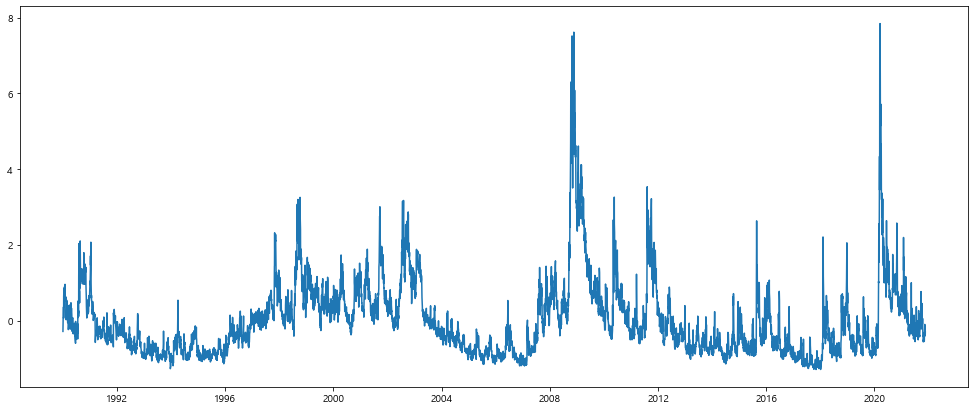

In [6]:
#Scaling
scaler = StandardScaler().fit(x_raw)
scaler
x_scaled = scaler.transform(x_raw)
#Plot
plt.figure(figsize=(17,7))
plt.plot( hist_m.index, x_scaled)
plt.show()

# 3 Kmean fit

In [8]:
k_summary = np.zeros([10,2])

for kk in range(1, 11):
    kmeans = KMeans(n_clusters=kk, random_state=0).fit(x_scaled)
    k_summary[kk-1,0] = kk
    k_summary[kk-1,1] = -kmeans.score(x_scaled)


# 4 Results analysis

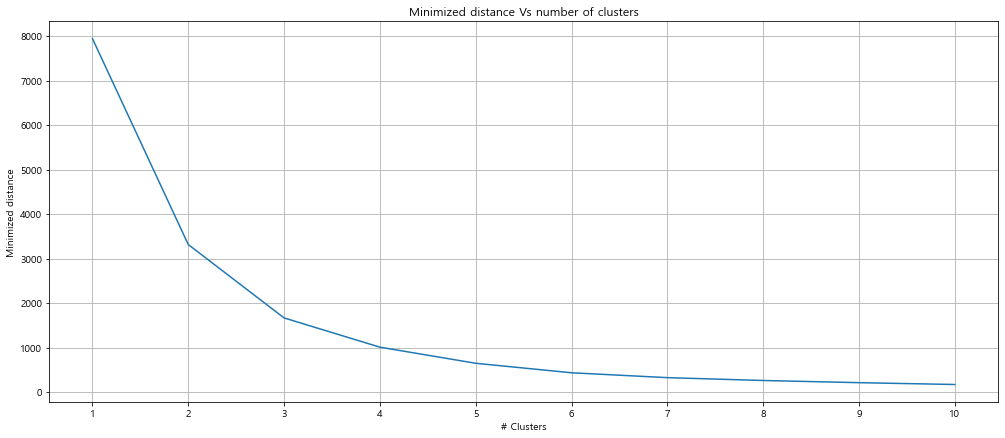

In [9]:
fig, axs = plt.subplots(1, 1, sharex="col")
fig.set_size_inches(17,7)
axs.plot(k_summary[:,0], k_summary[:,1])
axs.set_title("Minimized distance Vs number of clusters")
axs.grid(True)
plt.ylabel("Minimized distance")
plt.xlabel("# Clusters")
plt.xticks(k_summary[:,0])
plt.show()

# 5 Results plot

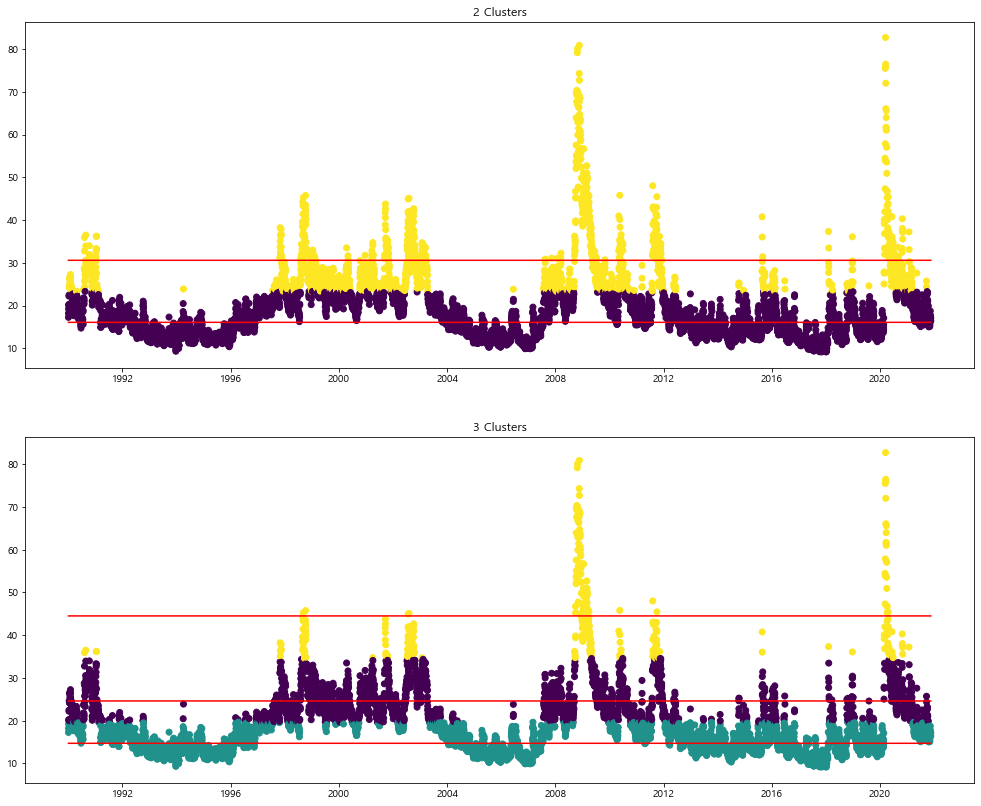

In [13]:
#Plot the best Clustering
k_best = [ 2, 3]
fig, axs = plt.subplots(len(k_best), 1)
fig.set_size_inches(17,7*len(k_best))
ind = 0
for kk in k_best:
    kmeans = KMeans(n_clusters=kk, random_state=0).fit(x_scaled)  
    axs[ind].scatter(  hist_m.index, x_raw, c=kmeans.labels_)
    for centroid in kmeans.cluster_centers_:
        axs[ind].plot(hist_m.index, np.ones_like(hist_m.index, dtype = "float64")*scaler.inverse_transform(centroid), "r")
    axs[ind].set_title(str(kk)+" Clusters") 
    ind = ind + 1

plt.show()

In [11]:
#Transition matrix
Trans_df = hist_m.copy(deep = True)
Trans_df["Old Label_t"] = kmeans.labels_
Trans_df["New Label_t"] = np.zeros_like(Trans_df["Old Label_t"])
Dict_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = ["Centroids"])
Dict_df.sort_values(by=['Centroids'], inplace=True)

for ii in Trans_df.index:
    Trans_df["New Label_t"].at[ii] = Dict_df.index[Trans_df["Old Label_t"][ii]]




Trans_df["Label_t+1"] = Trans_df["New Label_t"].shift(periods=-1)
unique = np.unique(Trans_df["New Label_t"])
Trans_prob = np.zeros([len(unique),len(unique)])
for u1 in unique:
  #Tot_row = np.count_nonzero(Trans_df["New Label_t"] == u1)
  for u2 in unique:
    Trans_prob[u1, u2] = np.count_nonzero(np.logical_and(Trans_df["New Label_t"] == u1, Trans_df["Label_t+1"] == u2))#/Tot_row

Trans_m = pd.DataFrame( data = Trans_prob, columns = unique)
print ("Row = start cluster; Column = end cluster")
Trans_m

Row = start cluster; Column = end cluster


,0,1,2
0,"4,623.00",203.00,1.00
1,204.00,"2,503.00",47.00
2,0.00,48.00,313.00


In [12]:
Trans_df[np.logical_and(Trans_df["New Label_t"] == 0, Trans_df["Label_t+1"] == 2)]

,Close,Old Label_t,New Label_t,Label_t+1
Date,,,,
2018-02-02,17.31,1,0,2.00
